Assignment 2: 

Name: Anuj Zore

UID: 119198457

Please submit to ELMS
- a PDF containing all outputs (by executing **Run all**)
- your ipynb notebook containing all the code

I understand the policy on academic integraty (collaboration and the use of online material).
Please sign your name here: Anuj Zore


In [ ]:
## Import necessary libraries here (You can add libraries you want to use here)

import cv2
import numpy as np
from scipy.io import loadmat
from scipy import ndimage
import matplotlib.pyplot as plt
from scipy import signal as sig
%matplotlib inline
from skimage.color import rgb2gray
from skimage.feature import peak_local_max
from skimage.feature import corner_harris, corner_peaks
from google.colab.patches import cv2_imshow

# Part 1: A Feature Tracker (50 Points)

## Overview

In the problem, you will implement a corner detector and feature tracker that track features from the image sequence hotel. Since this is a two part problem, we have included precomputed intermediate results in the *Data* section in case you’re unable to complete any portion.

<img src="https://drive.google.com/uc?id=1sBtKpU2mYEPZ9c2Cvw-DBuLBPK2gYwC-" width="700"/>

**Note:**  Do not use existing keypoint
detectors, trackers, or structure from motion code, such as found on the web, and OpenCV.

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
!gdown 1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
!unzip "/content/part1_images.zip" -d "/content/"
!gdown 1r-Pdino6MRLCEWX_sQOgd8D5AVsRc7Ym

Downloading...
From: https://drive.google.com/uc?id=1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
To: /content/part1_images.zip
100% 5.10M/5.10M [00:00<00:00, 47.8MB/s]
Archive:  /content/part1_images.zip
replace /content/part1_images/hotel.seq41.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Downloading...
From: https://drive.google.com/uc?id=1r-Pdino6MRLCEWX_sQOgd8D5AVsRc7Ym
To: /content/initial_keypoints.mat
100% 1.61k/1.61k [00:00<00:00, 3.42MB/s]


## Helper Functions

In [ ]:
def read_images(folder, num_images):
  arr_images = []
  for i in range(num_images):
    arr_images.append(cv2.imread(f'{folder}hotel.seq{i}.png'))
  return np.array(arr_images, dtype=np.float32)

def readgray(folder, num_images):
  arr_images = []
  for i in range(num_images):
    arr_images.append(cv2.imread(f'{folder}hotel.seq{i}.png', cv2.COLOR_BGR2GRAY))
  return np.array(arr_images, dtype=np.float32)

def trackPoints(pt_x, pt_y, im, ws):
 
  N = np.prod(pt_x.shape)
  nim = len(im)
  track_x = np.zeros((N, nim))
  track_y = np.zeros((N, nim))
  track_x[:,0] = pt_x.reshape(-1)
  track_y[:,0] = pt_y.reshape(-1)

  for t in range(nim-1):
    track_x[:, t+1], track_y[:, t+1] = getNextPoints(track_x[:, t], track_y[:, t], im[t,:,:], im[t+1,:,:], ws)

  return track_x, track_y

# read all 51 sequences of images
folder = '/content/part1_images/'
im = read_images(folder, 51) 
imm = readgray(folder, 51)

## 1.1 Keypoint Selection (15 pts)

For the first frame, use the second moment matrix to locate strong corners to use as keypoints.
These points will be tracked throughout the sequence in the second part of the problem. Choose a proper threshold so that edges and noisy patches are ignored. Do local non-maxima suppression over a 5x5 window centered at each point.
This should give several hundred good points to track.

### Code (5 pts)

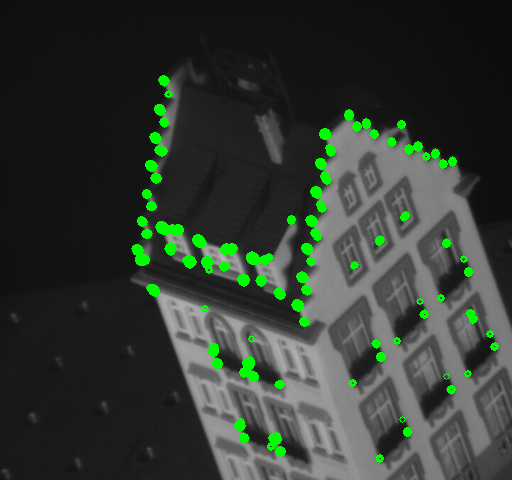

In [ ]:
def getKeypoints(img, tau):
  '''
  Detecting keypoints using Harris corner criterion
  img: input image
  tau: threshold 
  
  output: (N,2) array of [x,y] keypoints
  '''

  k = 0
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

  # smoothing image
  img_gaussian = cv2.GaussianBlur(gray,(3,3),0) 
      
  height = img.shape[0] 
  width = img.shape[1] 
  keypoints = np.zeros((height,width))
  
  Ix = cv2.Sobel(img_gaussian, cv2.CV_64F, 1, 0, ksize=3)
  Iy = cv2.Sobel(img_gaussian, cv2.CV_64F, 0, 1, ksize=3)

  # second moment matrix (Ix2, Iy2, Ixy)
  Ix2=np.square(Ix)
  Iy2=np.square(Iy)
  Ixy=Ix*Iy

  # Smoothing (locally weighted average)
  kernelsize = (5,5)
  sigma = 1.4

  Ix2 = cv2.GaussianBlur(Ix2, kernelsize, sigma)
  Iy2 = cv2.GaussianBlur(Iy2, kernelsize, sigma)
  Ixy = cv2.GaussianBlur(Ixy, kernelsize, sigma)

  offset = int( 5 / 2 )

  #calculating harris corner score
  for y in range(offset, height-offset):
      for x in range(offset, width-offset): 
          #second moment matrix 
          Hx2 = np.sum(Ix2[y-offset:y+1+offset, x-offset:x+1+offset])
          Hy2 = np.sum(Iy2[y-offset:y+1+offset, x-offset:x+1+offset])
          Hxy = np.sum(Ixy[y-offset:y+1+offset, x-offset:x+1+offset])

          H = np.array([[Hx2,Hxy],[Hxy,Hy2]])

          #calculating response function
          det=np.linalg.det(H)
          tr=np.matrix.trace(H)
          R=det-k*(tr**2) 
          keypoints[y-offset, x-offset]=R

  #normalizing keypoints to max 1
  cv2.normalize(keypoints, keypoints, 0, 1, cv2.NORM_MINMAX)

  return keypoints

def Display(img, keypoints, tau):
  height = img.shape[0] 
  width = img.shape[1]
  offset = int( 5 / 2 )
  for y in range(offset, height-offset):
      for x in range(offset, width-offset):
          value=keypoints[y, x]
          if value>tau:
            cv2.circle(img,(x,y),3,(0,255,0))

  cv2_imshow(img)

tau = 0.1
keypoints = getKeypoints(im[0], tau)
Display(im[0],keypoints,tau)

### Write-up 


* 1] Explain your implementation of getKeypoints()
*Ans: Implementation of getKeyPoints()
1] Initially, we convert our BGR image to grayscale. Additinally, image smoothing is performed with GaussianBlur.
2] Then we initiate a same dimensional array called "keyPoints". Second moment matrix are calculated for our image with Sobel.
3] We calculate Harris cornerness/corner score. Then keypoints are normalized between 0-1.
4] Display function plots keypoints on original images.

* 2] Display the first frame of the sequence overlaid with the detected keypoints. Ensure that they are clearly visible (plot with `color='g' and linewidths=3`)

Ans: Below image illustrating the first frame of the sequence overlaid with the detected keypoints.





## 1.2 Feature Tracking (35 pts)

Apply the Kanade-Lucas-Tomasi tracking procedure to track the keypoints found in part 1.1 (or the given keypoints in the *Data* section) throughout the hotel sequence. 

<img src="https://drive.google.com/uc?id=1dU4p4YcnXoQFnrNvleEty_4tDECkVW9Q" width="500"/>

Some keypoints will move out of the image frame over the course of the sequence. Discard any track if the predicted translation falls outside the image frame.

**Hint:**

*  From the 1st frame to the 2nd frame, use the detected keypoints at the first frame as initialization points. From the 2nd to 3rd frame, use the tracked positions at the 2nd frame as initialization. Note that the tracked keypoints in general are not at integer positions.

*  For each point, use a window size of 15 x 15.

Add codes to **plot** your tracked points overlayed in the **first sequence** and the **last sequence**. They should look similar to the second picture shown in the Overview section. 



### Code (10 pts)

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
!unzip "/content/part1_images.zip" -d "/content/"
!gdown 1r-Pdino6MRLCEWX_sQOgd8D5AVsRc7Ym
# Load Initial Key Points
data = loadmat('/content/initial_keypoints.mat')
X0 = data['Xo']
Y0 = data['Yo']



In [ ]:
# Required Library
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from PIL import Image  
from google.colab.patches import cv2_imshow

### Write-up (25 pts)

*   (5 pts) For all the keypoints, display (1) the keypoints at the first frame (as green) and (2) the tracked keypoints at the second frame (as red) on the first frame of the sequence.
*   (10 pts) For 20 random keypoints, draw the 2D path over the sequence of frames. That is, plot the progression of image coordinates for each of the 20 keypoints. Plot each of the paths on the same figure, overlaid on the first frame of the sequence.
*   (10 pts) On top of the first frame, plot the points which have moved out of frame at some point along the sequence.





 (1) the keypoints at the first frame (as green) and (2) the tracked keypoints at the second frame (as red) on the first frame of the sequence

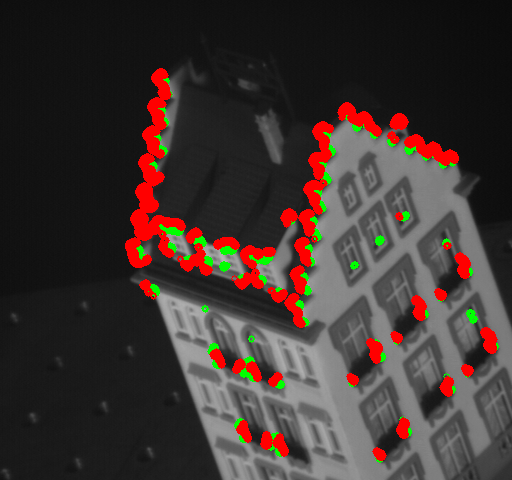

In [ ]:
def Display(img, keypoints, tau):
  height = img.shape[0] 
  width = img.shape[1]
  offset = int( 5 / 2 )
  for y in range(offset, height-offset):
      for x in range(offset, width-offset):
          value=keypoints[y, x]
          if value>tau:
            cv2.circle(img,(x,y),3,(0,0,255))

  cv2_imshow(img)

tau = 0.1
keypoints = getKeypoints(im[0], tau)
Display(im[0],keypoints,tau)

2] For 20 random keypoints, draw the 2D path over the sequence of frames. That is, plot the progression of image coordinates for each of the 20 keypoints. Plot each of the paths on the same figure, overlaid on the first frame of the sequence.

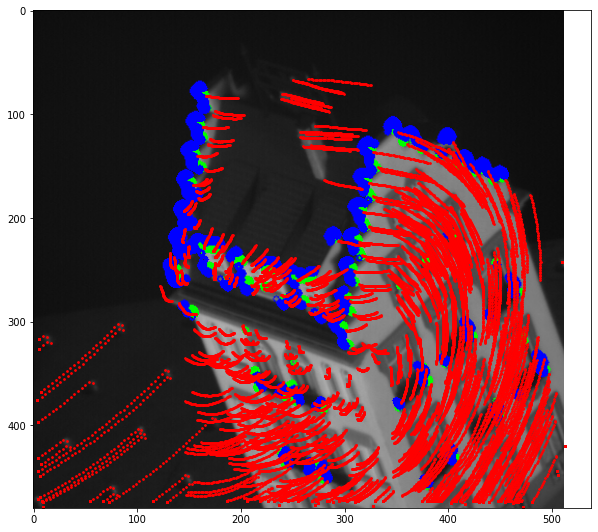

In [ ]:
def getNextPoints(x, y, im1, im2, ws):

  x_points = x.copy()
  y_points = y.copy()
  
  I_y, I_x = np.gradient(im1)
  
  h, w = im1.shape

  for i in range(len(x)): 
    if (x_points[i]+(ws*0.5) > w or x_points[i]-(ws*0.5) < 0 or y_points[i]+(ws*0.5) > h or y_points[i]-(ws*0.5) < 0):
        continue
    
    x_patch = cv2.getRectSubPix(I_x, (ws,ws), (x[i], y[i]))
    y_patch = cv2.getRectSubPix(I_y, (ws,ws), (x[i], y[i]))
    
    Ix2 = np.sum(x_patch**2)
    Iy2 = np.sum(y_patch**2)
    Ixy = np.sum(x_patch*y_patch)
    
    A = np.array([[Ix2, Ixy], [Ixy, Iy2]])
    
    for s in range(5):
      t_patch = cv2.getRectSubPix(im2, (ws,ws), (x_points[i], y_points[i])) - cv2.getRectSubPix(im1, (ws,ws), (x[i], y[i]))

      Ixt = np.sum(x_patch*t_patch)
      Iyt = np.sum(y_patch*t_patch)

      B = -np.array([Ixt, Iyt])
      try:
        disp = np.linalg.solve(A, B)
        x_points[i] = x_points[i] + disp[0]
        y_points[i] = y_points[i] + disp[1]
      except:
        break

  return x_points, y_points

ws = 15
tracked_pts = trackPoints(pt_x=X0, pt_y=Y0, im=imm, ws=ws)

# tracked_pts
x_track_pts = tracked_pts[0]
y_track_pts = tracked_pts[1]

plt.figure(figsize=(10, 10))
img_plt = np.array(im[0], dtype=np.uint8)
plt.imshow(img_plt, cmap='gray')
plt.scatter(tracked_pts[0].flatten(), tracked_pts[1].flatten(), s=3, c='r')

plt.show()

# Part 2: Shape Alignment (30 Points)

## Overview
In this problem, you will write a function that aligns two sets of points using global image transformation (similarity, affine, or perspective) and returns $T$  where $T$ is a transformation that maps non-zero points in $im1$ to non-zero points in $im2$. You may choose the alignment algorithm and the type of (global) transformation (e.g., rigid Euclidean, affine, perspective).


<img src="https://drive.google.com/uc?id=1PnWIy9ZdP9SGkmGNtFCJ-JzKLwmW-qaN" width="1000"/>

Test your code on the 25 image pairs provided in the supplementary material. We have included functions 
**(will check) evalAlignmentAll and displayAlignment to help with evaluation and display**.




## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy as cp
import random
SIFT = cv2.xfeatures2d.SIFT_create()



## Helper Functions

## Code (15 pts)

In [ ]:

def gradients(img):
    im = cv2.GaussianBlur(img,(3,3),2)
    kernely = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
    kernelx = np.array([[1,0,-1],[1,0,-1],[1,0,-1]])
    edges_x = cv2.filter2D(im,cv2.CV_64F,kernelx)
    edges_y = cv2.filter2D(im,cv2.CV_64F,kernely)
    return (edges_x,edges_y)

simA = cv2.imread('/content/part2_images/Bone_1.png',0)
transA = cv2.imread('/content/part2_images/Bone_2.png',0)

simAcp = cp.deepcopy(simA)
transAcp = cp.deepcopy(transA)

kernelxsimA,kernelysimA = gradients(simAcp)
kernelxtransA,kernelytransA = gradients(transAcp)

plt.figure(figsize=(100,100))
plt.subplot(3,2,1),plt.imshow(kernelxsimA,cmap='gray'),plt.title('horizontal gradient of simA',fontsize=100)
plt.subplot(3,2,2),plt.imshow(kernelysimA,cmap='gray'),plt.title('vertical gradient of simA',fontsize=100)
plt.subplot(3,2,3),plt.imshow(kernelxtransA,cmap='gray'),plt.title('horizontal gradient of transA',fontsize=100)
plt.subplot(3,2,4),plt.imshow(kernelytransA,cmap='gray'),plt.title('vertical gradient of transA',fontsize=100)
plt.subplot(3,2,5),plt.imshow(simA,cmap='gray'),plt.title('simA',fontsize=100)
plt.subplot(3,2,6),plt.imshow(transA,cmap='gray'),plt.title('transA',fontsize=100)

plt.show()

def harrisValues(Ix,Iy,w_size=5,alpha=0.03):
    Ixy = Ix*Iy
    Ixx = Ix**2
    Iyy = Iy**2
    c = np.zeros((w_size,w_size), dtype=np.float32);
    c[w_size // 2, w_size // 2] = 1.0
    w = cv2.GaussianBlur(c, (w_size,w_size), 0)
    R = np.zeros(Ix.shape).astype(np.float)
    for i in np.arange(w_size//2,Ix.shape[0]-w_size//2):
        for j in np.arange(w_size//2,Ix.shape[1]-w_size//2):     
            mini = i-w_size//2
            maxi = i+w_size//2+1
            minj = j-w_size//2
            maxj = j+w_size//2+1
            Mxy = (w*Ixy[mini:maxi,minj:maxj]).sum()
            M = np.array([[(w*Ixx[mini:maxi,minj:maxj]).sum(),Mxy],[Mxy,(w*Iyy[mini:maxi,minj:maxj]).sum()]])
            R[i,j] = np.linalg.det(M)-alpha*np.square(np.trace(M))
    return R

def norm(im):
    return cv2.normalize(im, im, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

def harris(img):
    im = cp.deepcopy(img)
    Ix,Iy = gradients(im)
    R = harrisValues(Ix,Iy)

    return R

simB = cv2.imread('/content/part2_images/Bone_1.png',0)
transB = cv2.imread('/content/part2_images/Bone_2.png',0)

RsimA = harris(simA)

RtransA = harris(transA)

RsimB = harris(simB)

RtransB = harris(transB)

plt.figure(figsize=(100,100))
plt.subplot(2,2,1),plt.imshow(norm(RsimA),cmap='jet'),plt.title('harris values of simA',fontsize=100)
plt.subplot(2,2,2),plt.imshow(norm(RtransA),cmap='jet'),plt.title('harris values of transA',fontsize=100)
plt.subplot(2,2,3),plt.imshow(norm(RsimB),cmap='jet'),plt.title('harris values of simB',fontsize=100)
plt.subplot(2,2,4),plt.imshow(norm(RtransB),cmap='jet'),plt.title('harris values of transB',fontsize=100)

plt.show()

def NMS(R,threshold,radius):
    Rbis = cp.deepcopy(R)
    maxr = np.amax(Rbis)
    threshold = threshold * maxr
    lPotential = []
    lCorners = []
    for i in np.arange(R.shape[0]):
        for j in np.arange(R.shape[1]):
            if( Rbis[i,j]<threshold):
                 Rbis[i,j] = 0
            else:
                lPotential.append((i,j))
        
    for pt in lPotential:
        i = pt[0]
        j = pt[1]
        mini = max(i-radius,0)
        maxi = min(Rbis.shape[0]-1,i+radius)
        minj = max(j-radius,0)
        maxj = min(Rbis.shape[1]-1,j+radius)
            
        if(Rbis[i,j]==Rbis[mini:maxi,minj:maxj].max()):
            lCorners.append((i,j))
            r = Rbis[i,j]
            Rbis[mini:maxi,minj:maxj] = 0
            Rbis[i,j] = r
    return lCorners

def harrisImp(img,threshold=0.1,radius=12):
    R = harris(img)
    return NMS(R,threshold,radius)

check = cv2.imread('check.bmp',0)
checkRot = cv2.imread('check_rot.bmp',0)
checkCorners = harrisImp(check)
checkRotCorners = harrisImp(checkRot)
simAcorners = harrisImp(simA)
transAcorners = harrisImp(transA)

simBcorners = harrisImp(simB)
transBcorners = harrisImp(transB)


plt.figure(figsize=(20,20))
plt.subplot(3,2,1),plt.imshow(simA,cmap='gray'),plt.title('harris corners in simA',fontsize=20),plt.scatter(
    x=[pt[1] for pt in simAcorners], 
    y=[pt[0] for pt in simAcorners], 
    s=15, facecolors="none", edgecolors="r"
)
plt.subplot(3,2,2),plt.imshow(transA,cmap='gray'),plt.title('harris corners in transA',fontsize=20),plt.scatter(
    x=[pt[1] for pt in transAcorners], 
    y=[pt[0] for pt in transAcorners], 
    s=15, facecolors="none", edgecolors="r"
)
plt.subplot(3,2,3),plt.imshow(simB,cmap='gray'),plt.title('harris corners in simB',fontsize=20),plt.scatter(
    x=[pt[1] for pt in simBcorners], 
    y=[pt[0] for pt in simBcorners], 
    s=15, facecolors="none", edgecolors="r"
)
plt.subplot(3,2,4),plt.imshow(transB,cmap='gray'),plt.title('harris corners in transB',fontsize=20),plt.scatter(
    x=[pt[1] for pt in transBcorners], 
    y=[pt[0] for pt in transBcorners], 
    s=15, facecolors="none", edgecolors="r"
)
plt.subplot(3,2,5),plt.imshow(check,cmap='gray'),plt.title('harris corners in transB',fontsize=20),plt.scatter(
    x=[pt[1] for pt in checkCorners], 
    y=[pt[0] for pt in checkCorners], 
    s=15, facecolors="none", edgecolors="r"
)

plt.subplot(3,2,6),plt.imshow(checkRot,cmap='gray'),plt.title('harris corners in transB',fontsize=20),plt.scatter(
    x=[pt[1] for pt in checkRotCorners], 
    y=[pt[0] for pt in checkRotCorners], 
    s=15, facecolors="none", edgecolors="r"
)
plt.show()

def features(img):
    keypoints = []
    im = cp.deepcopy(img)
    Ix,Iy = gradients(im)
    O = np.arctan2(Iy,Ix)
    lPoints = harrisImp(im)
    for p in lPoints:
        kpt = cv2.KeyPoint(p[1], p[0], _size=15, _angle=np.deg2rad(O[p[0],p[1]]))
        keypoints.append(kpt)
    im = cv2.drawKeypoints(im,keypoints,im,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return  (keypoints, im)



## Write-up (15 pt)

1. (5 pts) Give a brief explanation of your algorithm, initialization, and model of the transformation.

2. (10 pts) For each result, give:
  1.   The alignment display
  2.   The final error
  3.   The runtime






**Include your write-up here**

# Part 3: Object Instance Recognition (20 points)

## Overview
This problem explores the Lowe-style object instance recognition.

Implement the nearest neighbor distance ratio test using the pre-computed SIFT features SIFT_features.mat provided in the supplementary material. The Frame1, Frame2 indicate the 2D position, scales, and the orientation of the descriptors and Descriptor1, Descriptor2 are the correspondin 128-D SIFT features. Display the matches like this:

<img src="https://drive.google.com/uc?id=1mULTvHYeP5uj_vi7nwWThBHkDbv1eSue" width="1000"/>



## Data

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 10ByzpFbB-z178VGjwmCwc95wInD8vpNM # SIFT Features
!gdown 1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU # Stop sign image 1
!gdown 13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J # Stop sign image 1

Downloading...
From: https://drive.google.com/uc?id=10ByzpFbB-z178VGjwmCwc95wInD8vpNM
To: /content/SIFT_features.mat
100% 347k/347k [00:00<00:00, 104MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU
To: /content/stop1.jpg
100% 15.6k/15.6k [00:00<00:00, 29.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J
To: /content/stop2.jpg
100% 224k/224k [00:00<00:00, 68.0MB/s]


## Code (10 pts)

In [ ]:
# Libraries..

import cv2
import numpy as np
from scipy.io import loadmat
from scipy import ndimage
import matplotlib.pyplot as plt
from scipy import signal as sig
%matplotlib inline
from skimage.color import rgb2gray
from skimage.feature import peak_local_max
from skimage.feature import corner_harris, corner_peaks
from google.colab.patches import cv2_imshow

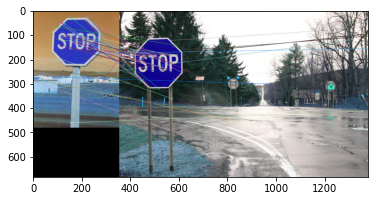

(<matplotlib.image.AxesImage at 0x7fef584e6ed0>, None)

In [ ]:
from skimage.feature.orb import ORB
import numpy as np
import cv2
from matplotlib import pyplot as plt

# matching by thresholding nearest neighbor distances
img1 = cv2.imread('/content/stop1.jpg', cv2.COLOR_BGR2GRAY)
img2 = cv2.imread('/content/stop2.jpg', cv2.COLOR_BGR2GRAY)

## inside the sift are:
## Descriptor1, Descriptor2: SIFT features from image 1 and image 2
## Frame1, Frame2: position, scale, rotation of keypoints
data = loadmat('/content/SIFT_features.mat')
Frame1 = data['Frame1']
Descriptor1 = data['Descriptor1'] #sift features - image 1
Descriptor1 = np.transpose(Descriptor1)
Frame2 = data['Frame2']
Descriptor2 = data['Descriptor2'] #sift features - image 2
Descriptor2 = np.transpose(Descriptor2)

sift = cv2.xfeatures2d.SIFT_create()

# # find the keypoints and descriptors - SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

## matches: a 2 x N array of indices that indicates which keypoints from image
## 1 match which points in image 2

bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
matches = bf.match(des1,des2)

matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, kp1, img2, kp2 ,matches[:50], img2, flags=2)

plt.imshow(img3),plt.show()

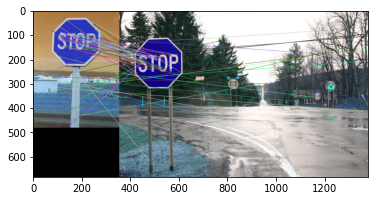

(<matplotlib.image.AxesImage at 0x7fef58426e90>, None)

In [ ]:
# matches by thresholding distance ratio.
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.feature.orb import ORB

img1 = cv2.imread('/content/stop1.jpg')
img2 = cv2.imread('/content/stop2.jpg')

sift = cv2.xfeatures2d.SIFT_create()

# # find the keypoints and descriptors -  SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2) #k denotes the best match level - 2 here for lowe's test

valid_points = []
for m,n in matches:
  if m.distance/n.distance < 0.80:
    valid_points.append([m])

img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, valid_points, img2, flags=2)

plt.imshow(img3),plt.show()

## Write-up (10 pts)

(5 pts) Display:

1. the matches by thresholding nearest neighbor distances.

2. the matches by thresholding the distance ratio. 

(5 pts) Describe the differences of (1) and (2).

1. The matches by thresholding nearest neighbor distances.

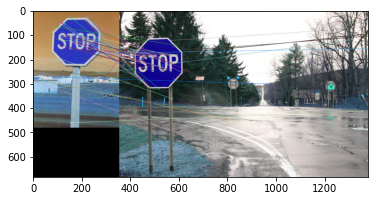



2. The matches by thresholding the distance ratio.
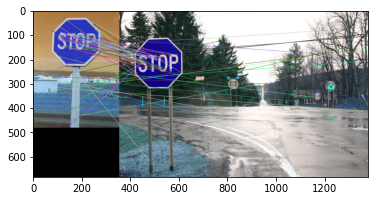

**Describe the differences of (1) and (2).**

In (1)Nearest neighbours implements nearest neighbours algorithm for detecting the possible nearest pair. Where as (2) used Threshold neighbour distance ratio calculate maximum value of the EDR for edge. In comparsion, TNDR shows better results for the given case senerio. Additionally, Nearest neighbours detects more false positives when observed. NND has more number of unpredictable results and keypoints whereas thresholding has more accurate keypoints forming object instance recognition.